In [736]:
import pandas as pd
import numpy as np
import tqdm
import geopy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, Binarizer
from sklearn import metrics
from geopy.geocoders import Nominatim
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

In [866]:
train = pd.read_csv('./west_nile/input/train.csv')
weather = pd.read_csv('./west_nile/input/weather.csv')
spray = pd.read_csv('./west_nile/input/spray.csv')
sample = pd.read_csv('./west_nile/input/sampleSubmission.csv')
test = pd.read_csv('./west_nile/input/test.csv')

In [872]:
sample.head()

,Id,WnvPresent
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [738]:
def missing_replacer(df, col):
    for position in df[df[col] == 'M'].index.values:
        df.at[position, col] = ((float(df.loc[position-1, col]) + 
                                    float(weather.loc[position+1, col]) / 2))

In [739]:
# Convert the dates to datetime format
weather['Date'] = pd.to_datetime(weather['Date'])
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])
spray['Date'] = pd.to_datetime(spray['Date'])

In [740]:
weather.at[2410, 'StnPressure'] = 29.34
weather.at[2411, 'StnPressure'] = 29.34
weather.at[2943, 'Depart'] = -5

In [741]:
# Change the 'T' to .001
weather['PrecipTotal'] = weather['PrecipTotal'].replace('  T', .001)

In [742]:
# Replace the 'M' values

missing_replacer(weather, 'Heat')
missing_replacer(weather, 'Cool')
missing_replacer(weather, 'WetBulb')
missing_replacer(weather, 'PrecipTotal')
missing_replacer(weather, 'StnPressure')
missing_replacer(weather, 'Tavg')
missing_replacer(weather, 'AvgSpeed')
missing_replacer(weather, 'Depart')

In [743]:
missing_replacer(weather, 'Depart')

In [744]:
# Assign new dtypes to the places we need them

weather['WetBulb'] = weather.WetBulb.astype('float')
weather['Heat'] = weather.Heat.astype('float')
weather['Tavg'] = weather.Tavg.astype('float')
weather['Depart'] = weather.Depart.astype('float')
weather['Cool'] = weather.Cool.astype('float')
weather['PrecipTotal'] = weather.PrecipTotal.astype('float')
weather['StnPressure'] = weather.StnPressure.astype('float')
weather['AvgSpeed'] = weather.AvgSpeed.astype('float')

In [745]:
# Get rid of all station 2 input
weather = weather[weather['Station'] == 1]

In [746]:
weather = weather.drop(['Sunrise', 'Sunset', 'CodeSum', 'Depth', 'Water1', 
                        'SnowFall', 'SeaLevel'], axis = 1)

In [747]:
df = train.merge(weather, how = 'left', on = 'Date')

In [748]:
species = pd.get_dummies(df['Species'])
df = pd.concat([df, species], axis = 1)

In [749]:
y = df['WnvPresent']
X = df.drop(['Date', 'Address', 'Species', 'Block', 'Street', 'AddressNumberAndStreet',
            'AddressAccuracy', 'Station', 'WnvPresent', 'Trap', 'Tmin', 'Tmax', 'Cool'], 
            axis = 1)

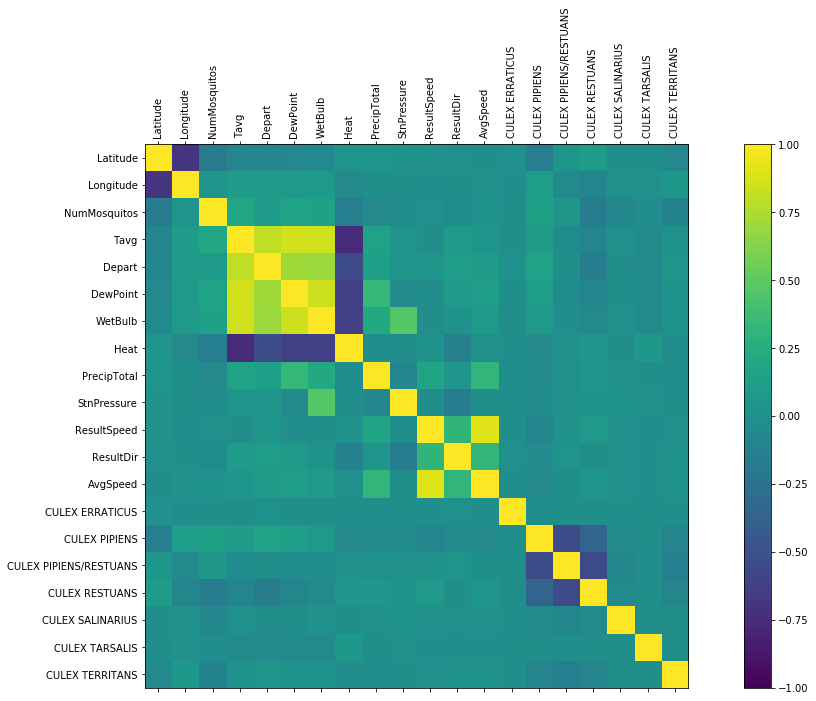

In [750]:
correlations = X.corr()
# plot correlation matrix
fig, ax = plt.subplots(figsize=(20, 10))
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(X.columns),1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(X.columns.values, rotation='vertical')
ax.set_yticklabels(X.columns.values)
plt.show()

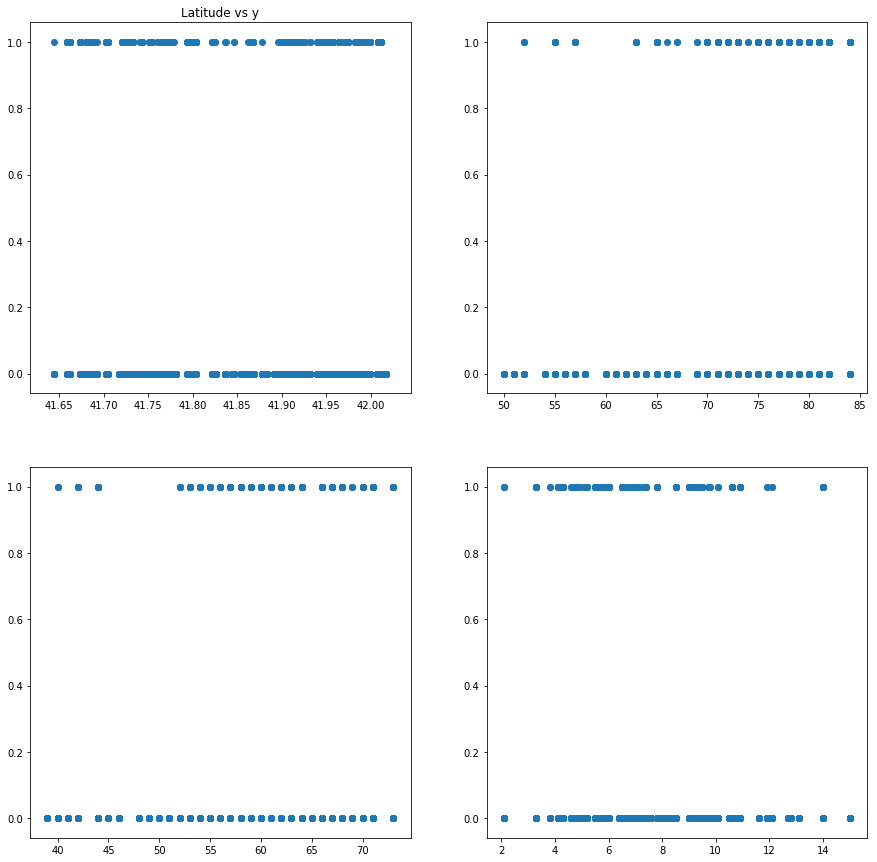

In [751]:
fig, ax = plt.subplots(2, 2, figsize=(15,15))
ax[0, 0].scatter(X['Latitude'], y)
ax[0, 0].set_title('Latitude vs y')
ax[0, 1].scatter(X['Tavg'], y)
ax[1, 0].scatter(X['DewPoint'], y)
ax[1, 1].scatter(X['AvgSpeed'], y);

In [752]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42,
                                                    stratify = y)

lg = LogisticRegression()
ss = StandardScaler()

X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [753]:
lg.fit(X_train, y_train)
lg_preds = lg.predict(X_test)
lg_probs = lg.predict_proba(X_test)
print(metrics.confusion_matrix(y_test, lg_preds))
print('accuracy =',round(metrics.accuracy_score(y_test, lg_preds), 3))
print('roc_auc_score =', round(metrics.roc_auc_score(y_test, lg_probs[:, 1]), 3))

[[2985    2]
 [ 165    0]]
accuracy = 0.947
roc_auc_score = 0.794


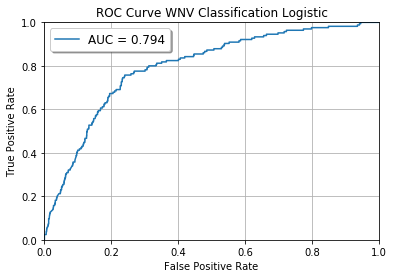

In [754]:
fig, ax = plt.subplots()
fpr, tpr, threshold = metrics.roc_curve(y_test, lg_probs[:, 1])
ax.plot(fpr, tpr, label = 'AUC = 0.794')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC Curve WNV Classification Logistic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
legend = ax.legend(loc = 'upper left', shadow = True, fontsize = 'large')
plt.grid(True) 

In [756]:
new_preds = Binarizer(threshold = 0.2).transform(lg_probs)
print(metrics.confusion_matrix(y_test, new_preds[:, 1]))
print('accuracy =', metrics.accuracy_score(y_test, new_preds[:, 1]))
print('precision =', metrics.precision_score(y_test, new_preds[:, 1]))

[[2875  112]
 [ 134   31]]
accuracy = 0.921954314721
precision = 0.216783216783


In [757]:
coefs = pd.DataFrame()
coefs['Values'] = lg.coef_[0]
coefs['Variable'] = X.columns

### RFC

In [758]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc_probs = rfc.predict_proba(X_test)
rfc_preds = rfc.predict(X_test)
print(metrics.confusion_matrix(y_test, rfc_preds))
print(metrics.accuracy_score(y_test, rfc_preds))
rfc_auc = round(metrics.roc_auc_score(y_test, rfc_probs[:, 1]), 3)
print(rfc_auc)

[[2942   45]
 [ 142   23]]
0.940672588832
0.758


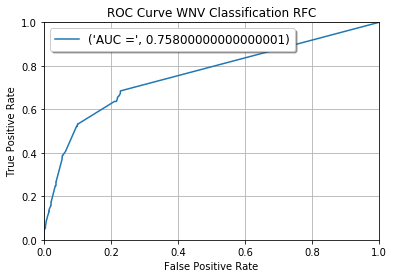

In [759]:
fig, ax = plt.subplots()
fpr, tpr, threshold = metrics.roc_curve(y_test, rfc_probs[:, 1])
ax.plot(fpr, tpr, label = ('AUC =', rfc_auc))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC Curve WNV Classification RFC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
legend = ax.legend(loc = 'upper left', shadow = True, fontsize = 'large')

plt.grid(True)

### KNN

In [760]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn_probs = knn.predict_proba(X_test)
knn_preds = knn.predict(X_test)
print(metrics.confusion_matrix(y_test, knn_preds))
print(metrics.accuracy_score(y_test, knn_preds))
knn_auc = round(metrics.roc_auc_score(y_test, knn_probs[:, 1]), 3)
print(knn_auc)

[[2943   44]
 [ 148   17]]
0.939086294416
0.717


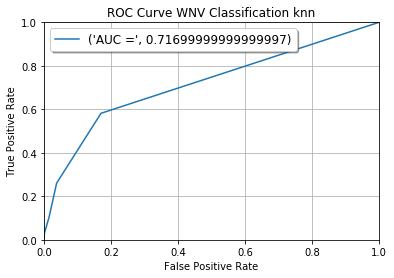

In [761]:
fig, ax = plt.subplots()
fpr, tpr, threshold = metrics.roc_curve(y_test, knn_probs[:, 1])
ax.plot(fpr, tpr, label = ('AUC =', knn_auc))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC Curve WNV Classification knn')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
legend = ax.legend(loc = 'upper left', shadow = True, fontsize = 'large')
plt.grid(True)

### Model Improvement
How can I engineer the features differently

How can the spray data be used here

#### Try making dummy variables for month and year
Go through Date column and convert to a number for each year

In [762]:
month = pd.get_dummies(df['Date'].dt.month)
month = month.drop(5, axis = 1)
X = pd.concat([X, month], axis = 1)

In [764]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42,
                                                    stratify = y)

lg = LogisticRegression()
ss = StandardScaler()

X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [765]:
lg.fit(X_train, y_train)
lg_preds = lg.predict(X_test)
lg_probs = lg.predict_proba(X_test)
print(metrics.confusion_matrix(y_test, lg_preds))
print('accuracy =',round(metrics.accuracy_score(y_test, lg_preds), 3))
lg_auc = round(metrics.roc_auc_score(y_test, lg_probs[:, 1]), 3)
print('roc_auc_score =', lg_auc)

[[2977   10]
 [ 159    6]]
accuracy = 0.946
roc_auc_score = 0.836


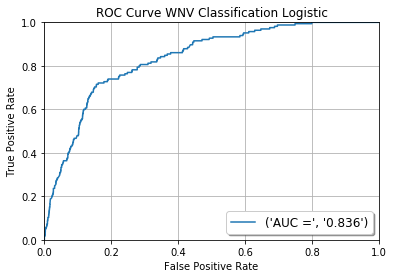

In [766]:
fig, ax = plt.subplots()
fpr, tpr, threshold = metrics.roc_curve(y_test, lg_probs[:, 1])
ax.plot(fpr, tpr, label = ('AUC =', str(lg_auc)))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC Curve WNV Classification Logistic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
legend = ax.legend(loc = 'lower right', shadow = True, fontsize = 'large')
plt.grid(True)

In [768]:
new_preds = Binarizer(threshold = 0.17).transform(lg_probs)
print(metrics.confusion_matrix(y_test, new_preds[:, 1]))
print('accuracy =', metrics.accuracy_score(y_test, new_preds[:, 1]))
print('precision =', metrics.precision_score(y_test, new_preds[:, 1]))
print('baseline =', 1 - (y_test.sum()/len(y_test)))
print('count of occurances: {} with a total of {}'.format(y_test.sum(), len(y_test)))
print('recall =', metrics.recall_score(y_test, new_preds[:,1]))

[[2784  203]
 [ 104   61]]
accuracy = 0.902601522843
precision = 0.231060606061
baseline = 0.9476522842639594
count of occurances: 165 with a total of 3152
recall = 0.369696969697


### Searching for Bias: What are locations of those false negatives?
Can I graph my confusion matrix? Will I see anything if I superimpose my predictions onto a map?

In [769]:
# Make new df, 'test_df' that has predictions & locations, then plot
locs = df[['Latitude', 'Longitude']]
y_df = pd.DataFrame(y_test)
y_df = y_df.join(locs, how='left')
idx = y_df.index.values
pred_df = pd.DataFrame(new_preds)
pred_df = pred_df.drop(0, axis = 1)
pred_df['idx'] = idx
pred_df = pred_df.set_index('idx')
test_df = y_df.join(pred_df, how='left')
test_df = test_df.rename(columns={1: 'one'})

In [770]:
lst = []
for row in test_df.index.values:
    if test_df.loc[row, 'WnvPresent'] == 0:
        if test_df.loc[row, 'one'] == 0:
            lst.append('TN')
        elif test_df.loc[row, 'one'] == 1:
            lst.append('FP')
    elif test_df.loc[row, 'WnvPresent'] == 1:
        if test_df.loc[row, 'one'] == 1:
            lst.append('TP')
        elif test_df.loc[row, 'WnvPresent'] == 1:
            lst.append('FN')
test_df['scores'] = lst

In [771]:
colors = {'TN':'yellow', 'TP':'red', 'FN':'purple', 'FP':'green'}
sizes = {'TN':6, 'TP':50, 'FN':50, 'FP':20}

(41.6, 42.1)

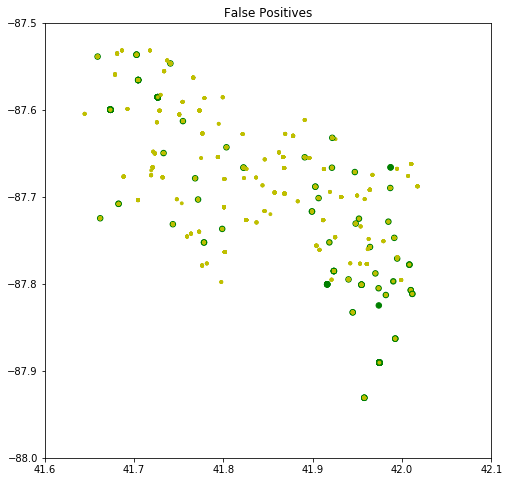

In [772]:
fig, ax = plt.subplots(figsize=(8,8))
plt.scatter(test_df['Latitude'], test_df['Longitude'], c=test_df['scores'].apply(
    lambda x: 'green' if x == 'FP' else 'y'), s=test_df['scores'].apply(lambda x: 
                                                                    30 if x == 'FP' else 8))
plt.title('False Positives')
plt.ylim(-88.0, -87.5)
plt.xlim(41.6, 42.1)

(41.6, 42.1)

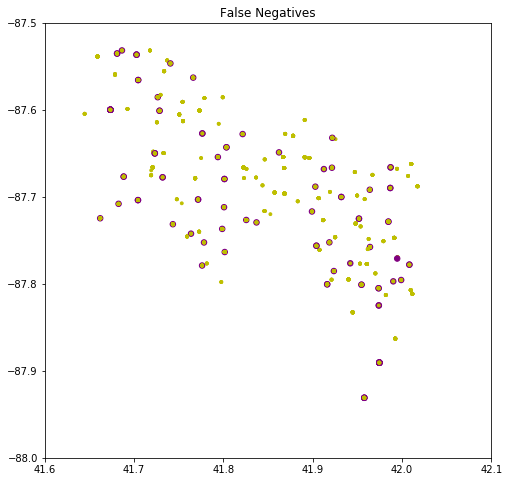

In [773]:
fig, ax = plt.subplots(figsize=(8,8))
plt.scatter(test_df['Latitude'], test_df['Longitude'], c=test_df['scores'].apply(
    lambda x: 'purple' if x == 'FN' else 'y'), s=test_df['scores'].apply(lambda x: 
                                                                    30 if x == 'FN' else 8))
plt.title('False Negatives')
plt.ylim(-88.0, -87.5)
plt.xlim(41.6, 42.1)

(41.6, 42.1)

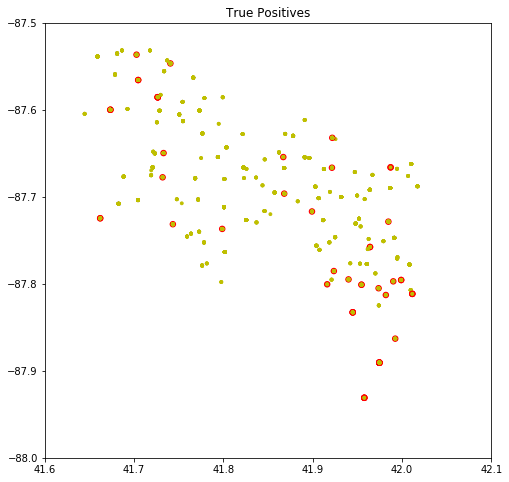

In [774]:
fig, ax = plt.subplots(figsize=(8,8))
plt.scatter(test_df['Latitude'], test_df['Longitude'], c=test_df['scores'].apply(
    lambda x: 'r' if x == 'TP' else 'y'), s=test_df['scores'].apply(lambda x: 
                                                                    30 if x == 'TP' else 8))
plt.title('True Positives')
plt.ylim(-88.0, -87.5)
plt.xlim(41.6, 42.1)

(41.6, 42.1)

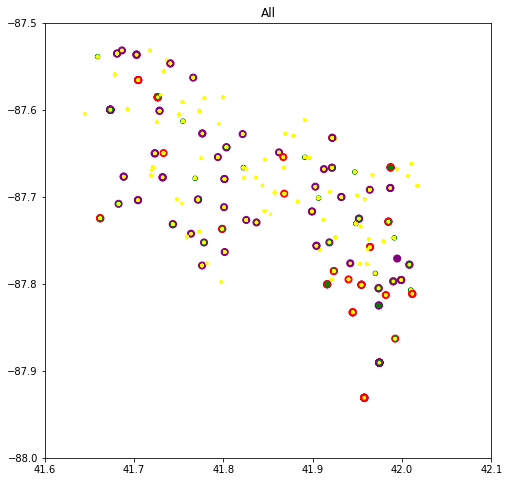

In [775]:
fig, ax = plt.subplots(figsize=(8,8))
plt.scatter(test_df['Latitude'], test_df['Longitude'], c=test_df['scores'].apply(
    lambda x: colors[x]), s=test_df['scores'].apply(lambda x: sizes[x]))
plt.title('All')
plt.ylim(-88.0, -87.5)
plt.xlim(41.6, 42.1)

It seems that our true positives tend to be in the bottom-right sector of the graph. But false negatives tend to be all spread out. 

### Messing with Geography & Spray
Goal now is to make a model, and see what the beta coefficient is for our spray column. 
I would like to include a column that incorporates spray into the model to see if that is a strong predictor of whether WNV will occur or not. 

Import geopy: use vincenty

In [776]:
# Get just the longitudes from the traps
traps = train[['Trap', 'Longitude', 'Latitude']]
traps = traps.drop_duplicates()

In [777]:
# Make a list of coordinates of all traps
trap_cords = []
for row in traps.index.values:
    trap_cords.append((traps.Longitude[row], traps.Latitude[row]))

# Make list of coordinates of all spray events
ts = pd.to_datetime('2013 - 1 - 1')
s_2013 = spray[spray.Date > ts]
s_2013 = s_2013[['Latitude', 'Longitude']].drop_duplicates()
spray_cords = []
for val in s_2013.index.values:
    spray_cords.append((s_2013.Longitude[val], s_2013.Latitude[val]))

In [778]:
# Make a list of lists. Each lower list is the distance from a trap to all spray events.
locs = []
for j in tqdm.tqdm(trap_cords):
    locs.append([vincenty(j, cord).kilometers for cord in spray_cords])
    

100%|██████████| 138/138 [00:28<00:00,  4.86it/s]


In [779]:
# Get the smallest distance from each list made above
min_distances = []
for distances in range(len(locs)):
    min_distances.append(min(locs[distances]))
traps['dist'] = min_distances

In [780]:
# Make a dictionary so that we can incorporate the distances onto the X dataframe
# There are probably better ways to do this
trap_dict = dict(zip(traps.Trap, traps.dist))

In [781]:
# Make a list that is same length of train data, appending distances to trap for
# each trap. We use the name of the trap from the train data as the key for our dictionary
yeah_baby = []
for row in tqdm.tqdm(range(len(train))):
    yeah_baby.append(trap_dict[train.Trap[row]])

100%|██████████| 10506/10506 [00:00<00:00, 74676.29it/s]


In [782]:
# Update the X-Matrix with our new values. Note, this can be done because the lists are
# the same length
X['distances'] = yeah_baby

In [784]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42,
                                                    stratify = y)

lg = LogisticRegression()
ss = StandardScaler()

X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [785]:
lg.fit(X_train, y_train)
lg_preds = lg.predict(X_test)
lg_probs = lg.predict_proba(X_test)
print(metrics.confusion_matrix(y_test, lg_preds))
print('accuracy =',round(metrics.accuracy_score(y_test, lg_preds), 3))
print('roc_auc_score =', round(metrics.roc_auc_score(y_test, lg_probs[:, 1]), 3))

[[2978    9]
 [ 163    2]]
accuracy = 0.945
roc_auc_score = 0.833


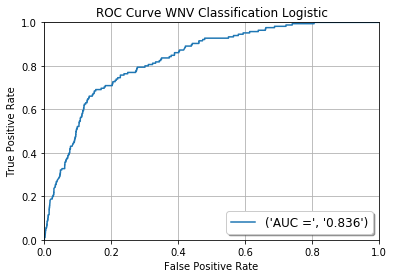

In [786]:
fig, ax = plt.subplots()
fpr, tpr, threshold = metrics.roc_curve(y_test, lg_probs[:, 1])
ax.plot(fpr, tpr, label = ('AUC =', str(lg_auc)))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC Curve WNV Classification Logistic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
legend = ax.legend(loc = 'lower right', shadow = True, fontsize = 'large')
plt.grid(True)

In [787]:
new_preds = Binarizer(threshold = 0.25).transform(lg_probs)
print(metrics.confusion_matrix(y_test, new_preds[:, 1]))
print('accuracy =', metrics.accuracy_score(y_test, new_preds[:, 1]))
print('precision =', metrics.precision_score(y_test, new_preds[:, 1]))
print('baseline =', 1 - (y_test.sum()/len(y_test)))
print('count of occurances: {} with a total of {}'.format(y_test.sum(), len(y_test)))
print('recall =', metrics.recall_score(y_test, new_preds[:,1]))

[[2922   65]
 [ 134   31]]
accuracy = 0.936865482234
precision = 0.322916666667
baseline = 0.9476522842639594
count of occurances: 165 with a total of 3152
recall = 0.187878787879


In [788]:
coefs_dist = pd.DataFrame()
coefs_dist['Values'] = lg.coef_[0]
coefs_dist['Variable'] = X.columns

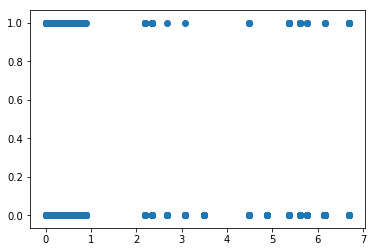

In [789]:
plt.scatter(X.distances, y)

In [790]:
np.corrcoef(X.distances, y)

array([[ 1.        ,  0.00231657],
       [ 0.00231657,  1.        ]])

In [791]:
lst = []
for col in range(len(X.columns)):
    lst.append(np.round(np.corrcoef(X[X.columns.values[col]], y)[0, 1], 5))
names = X.columns.values
evaluation = pd.DataFrame()
evaluation['name'] = names
evaluation['coeff'] = lst
evaluation.sort_values('coeff')

In [792]:
evaluation = pd.DataFrame()
evaluation['name'] = names
evaluation['coeff'] = lst
evaluation.sort_values('coeff')

,name,coeff
21,6,-0.09745
16,CULEX RESTUANS,-0.09209
22,7,-0.08965
1,Longitude,-0.06035
7,Heat,-0.05681
10,ResultSpeed,-0.05118
19,CULEX TERRITANS,-0.03457
12,AvgSpeed,-0.02996
9,StnPressure,-0.02162
8,PrecipTotal,-0.02147


### Updated Thoughts
Well, an interesting thing to note:
NumMosquitos has highest correlation with WNV presence. How does distance to a spray relate with the total number of Mosquitos? 
Distance to trap really does not correlate well with WNV presence...but it may correlate with num mosqs, which then in turn may correlate with num mosqs

In [793]:
np.corrcoef(X.NumMosquitos, X.distances)

array([[ 1.        ,  0.09751106],
       [ 0.09751106,  1.        ]])

In [794]:
lst = []
for col in range(len(X.columns)):
    lst.append(np.round(np.corrcoef(X[X.columns.values[col]], X.NumMosquitos)[0, 1], 5))
names = X.columns.values
evaluation = pd.DataFrame()
evaluation['name'] = names
evaluation['coeff'] = lst
evaluation.sort_values('coeff')

,name,coeff
0,Latitude,-0.18481
16,CULEX RESTUANS,-0.15839
7,Heat,-0.13557
24,9,-0.10814
19,CULEX TERRITANS,-0.09614
17,CULEX SALINARIUS,-0.06289
21,6,-0.05981
20,5,-0.05629
8,PrecipTotal,-0.05623
9,StnPressure,-0.02773


### Next Idea:
Analyze 2013 to see if spraying has an immediate effect on the number of mosquitos captured. 
Line graph with x-axis being date and y-axis being number of mosquitos. Do this for 5 traps in heavy spray zones and 5 traps in non-spray zones. Make markers on graph to denote a spray event. See if line graph goes up/down immediately following the event. 

In [795]:
df['Date'].dt.year == 2013

0        False
1        False
2        False
3        False
4        False
5        False
6        False
7        False
8        False
9        False
10       False
11       False
12       False
13       False
14       False
15       False
16       False
17       False
18       False
19       False
20       False
21       False
22       False
23       False
24       False
25       False
26       False
27       False
28       False
29       False
         ...  
10476     True
10477     True
10478     True
10479     True
10480     True
10481     True
10482     True
10483     True
10484     True
10485     True
10486     True
10487     True
10488     True
10489     True
10490     True
10491     True
10492     True
10493     True
10494     True
10495     True
10496     True
10497     True
10498     True
10499     True
10500     True
10501     True
10502     True
10503     True
10504     True
10505     True
Name: Date, Length: 10506, dtype: bool

### Precipation: Feature Engineering
Below, we will add a column to X that shows the sum of precipitation for n amount of days before the date given in a particular row on the train/test set. Thus, we will get a precip_sum for each row in our train/test data set. 

In [796]:
# Make list that has sum of all days specified in delta
delta = pd.Timedelta('-21 days')
precips = []
for date in weather.Date:
    precips.append(weather.loc[((weather['Date'] > (date + delta)) & 
                                (weather['Date'] <= date))].PrecipTotal.sum())
weather['precips'] = precips

In [798]:
df = df.merge(weather[['Date', 'precips']], how = 'left', on = 'Date')

In [799]:
np.corrcoef(df['precips'], y)

array([[ 1.        ,  0.03463149],
       [ 0.03463149,  1.        ]])

In [801]:
X['precips'] = df['precips']
X = X.drop('WetBulb', axis = 1)
X = X.drop('NumMosquitos', axis = 1)

### Retest our model
Remove Some Columns: Year dummy variables, Wetbulb

Add some columns:


In [1210]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42,
                                                    stratify = y)

lg = LogisticRegression()
ss = StandardScaler()

X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [1211]:
lg.fit(X_train, y_train)
lg_preds = lg.predict(X_test)
lg_probs = lg.predict_proba(X_test)
print(metrics.confusion_matrix(y_test, lg_preds))
print('accuracy =',round(metrics.accuracy_score(y_test, lg_preds), 3))
lg_auc = round(metrics.roc_auc_score(y_test, lg_probs[:, 1]), 3)
print('roc_auc_score =', lg_auc)

[[2987    0]
 [ 165    0]]
accuracy = 0.948
roc_auc_score = 0.794


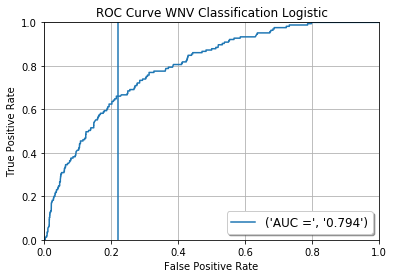

In [1213]:
fig, ax = plt.subplots()
fpr, tpr, threshold = metrics.roc_curve(y_test, lg_probs[:, 1])
ax.plot(fpr, tpr, label = ('AUC =', str(lg_auc)))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC Curve WNV Classification Logistic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
legend = ax.legend(loc = 'lower right', shadow = True, fontsize = 'large')
plt.grid(True)
plt.axvline(x=0.22)

In [812]:
new_preds = Binarizer(threshold = 0.2).transform(lg_probs)
print(metrics.confusion_matrix(y_test, new_preds[:, 1]))
print('accuracy =', metrics.accuracy_score(y_test, new_preds[:, 1]))
print('precision =', metrics.precision_score(y_test, new_preds[:, 1]))
print('baseline =', 1 - (y_test.sum()/len(y_test)))
print('recall = {}'.format(round(metrics.recall_score(y_test, new_preds[:,1]), 3)))

[[2927   60]
 [ 143   22]]
accuracy = 0.935596446701
precision = 0.268292682927
baseline = 0.9476522842639594
recall = 0.133


### Finally: Adapt our Model for the test data
First: get our test data ready to go...basically follow the steps for train

In [854]:
df_test = test.merge(weather, how='left', on='Date')
month = pd.get_dummies(df_test['Date'].dt.month)
df_test = pd.concat([df_test, month], axis = 1)
species = pd.get_dummies(df_test['Species'])
df_test = pd.concat([df_test, species], axis = 1)
df_test = df_test.drop(['UNSPECIFIED CULEX'], axis=1)
df_test = df_test.drop(['Id', 'Date', 'Address', 'Block', 'Street', 'Trap', 
                        'AddressNumberAndStreet', 'Tmax', 'Tmin', 'Cool', 'WetBulb',
                        'Species', 'AddressAccuracy', 'Station'], axis=1)

In [856]:
traps = test[['Trap', 'Longitude', 'Latitude']]
traps = traps.drop_duplicates()
trap_cords = []
for row in traps.index.values:
    trap_cords.append((traps.Longitude[row], traps.Latitude[row]))

# Make list of coordinates of all spray events
ts = pd.to_datetime('2013 - 1 - 1')
s_2013 = spray[spray.Date > ts]
s_2013 = s_2013[['Latitude', 'Longitude']].drop_duplicates()
spray_cords = []
for val in s_2013.index.values:
    spray_cords.append((s_2013.Longitude[val], s_2013.Latitude[val]))
    
locs = []
for j in tqdm.tqdm(trap_cords):
    locs.append([vincenty(j, cord).kilometers for cord in spray_cords])

min_distances = []
for distances in range(len(locs)):
    min_distances.append(min(locs[distances]))
traps['dist'] = min_distances

trap_dict = dict(zip(traps.Trap, traps.dist))    

yeah_baby = []
for row in tqdm.tqdm(range(len(test))):
    yeah_baby.append(trap_dict[test.Trap[row]])
    
df_test['distances'] = yeah_baby

100%|██████████| 116293/116293 [00:01<00:00, 84299.13it/s]


In [861]:
lg = LogisticRegression()
ss = StandardScaler()

X_train = X
X_test = df_test

Xs = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

lg.fit(X_train, y)
lg_probs = lg.predict_proba(X_test)

new_preds = Binarizer(threshold = 0.2).transform(lg_probs)


In [885]:
test['WnvPresent'] = lg_probs[:, 1]
new_preds = test[['Id', 'WnvPresent']]

In [886]:
new_preds.to_csv('./predictions.csv', index=False)

In [887]:
lg_preds = lg.predict(X_test)

### Random things

In [1158]:
X.head()

,Latitude,Longitude,Tavg,Depart,DewPoint,Heat,PrecipTotal,StnPressure,ResultSpeed,ResultDir,...,CULEX SALINARIUS,CULEX TARSALIS,CULEX TERRITANS,5,6,7,8,9,distances,precips
0,41.954690,-87.800991,74.0,10.0,58,0.0,0.0,29.39,5.8,18,...,0,0,0,1,0,0,0,0,0.019174,1.792
1,41.954690,-87.800991,74.0,10.0,58,0.0,0.0,29.39,5.8,18,...,0,0,0,1,0,0,0,0,0.019174,1.792
2,41.994991,-87.769279,74.0,10.0,58,0.0,0.0,29.39,5.8,18,...,0,0,0,1,0,0,0,0,0.016445,1.792
3,41.974089,-87.824812,74.0,10.0,58,0.0,0.0,29.39,5.8,18,...,0,0,0,1,0,0,0,0,0.418028,1.792
4,41.974089,-87.824812,74.0,10.0,58,0.0,0.0,29.39,5.8,18,...,0,0,0,1,0,0,0,0,0.418028,1.792


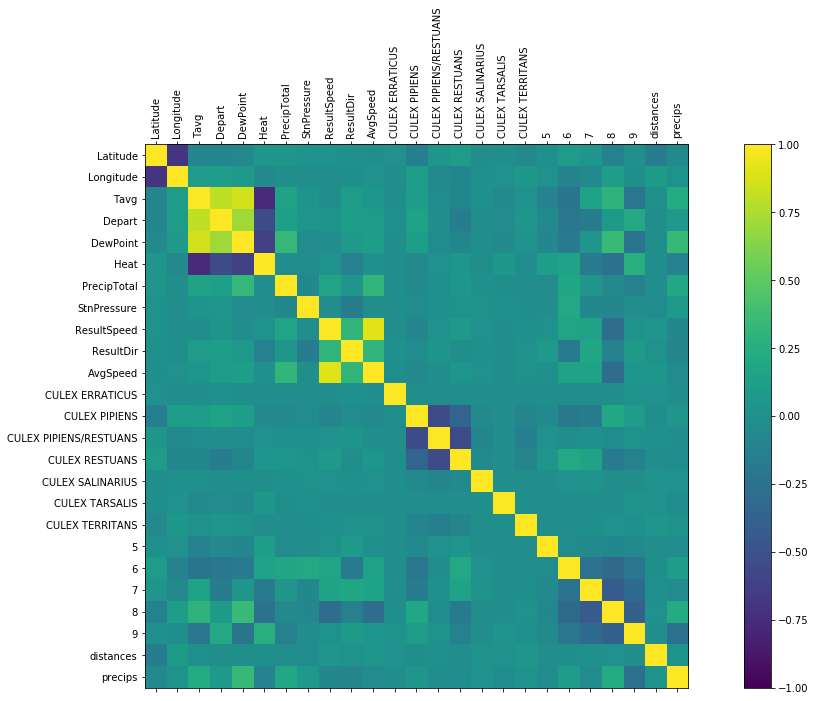

In [1159]:
correlations = X.corr()
# plot correlation matrix
fig, ax = plt.subplots(figsize=(20, 10))
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(X.columns),1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(X.columns.values, rotation='vertical')
ax.set_yticklabels(X.columns.values)
plt.show()

In [1207]:
evaluation[['name', 'coeff']].sort_values('coeff')

,name,coeff
19,june,-0.09745
14,CULEX RESTUANS,-0.09209
20,july,-0.08965
1,Longitude,-0.06035
5,Heat,-0.05681
8,ResultSpeed,-0.05118
17,CULEX TERRITANS,-0.03457
10,AvgSpeed,-0.02996
7,StnPressure,-0.02162
6,PrecipTotal,-0.02147


In [ ]:
df = df.where(df == -1, df - 146200)

In [ ]:
DataFrame.set_value(index, col, value, takeable=False)¶


In [1183]:
evaluation = evaluation.set_value(18, 'name', 'may')
evaluation = evaluation.set_value(19, 'name', 'june')
evaluation = evaluation.set_value(20, 'name', 'july')
evaluation = evaluation.set_value(21, 'name', 'aug')
evaluation = evaluation.set_value(22, 'name', 'september')


In [1175]:
evaluation.rename(columns={6:'june', 7:'july', 8:'august', 9:'september'}, inplace=True)

Text(0.5,1,'Feature Correlation Bargraph against Target')

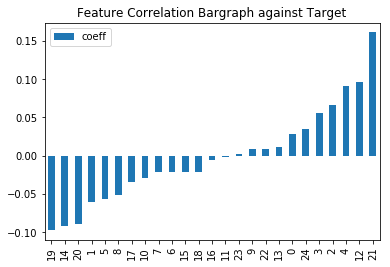

In [1208]:
lst = []
for col in range(len(X.columns)):
    lst.append(np.round(np.corrcoef(X[X.columns.values[col]], y)[0, 1], 5))
names = X.columns.values
evaluation = pd.DataFrame()
evaluation['name'] = names
evaluation['coeff'] = lst
evaluation.sort_values('coeff').plot.bar()
plt.title('Feature Correlation against Target')

In [1180]:
evaluation.tail()

,name,coeff
20,7,-0.08965
21,8,0.16065
22,9,0.00908
23,distances,0.00232
24,precips,0.03463


In [1196]:
len(evaluation.sort_values('coeff').name.values)

25

In [1201]:
evaluation.sort_values('coeff').coeff.values

array([-0.09745, -0.09209, -0.08965, -0.06035, -0.05681, -0.05118,
       -0.03457, -0.02996, -0.02162, -0.02147, -0.02137, -0.02112,
       -0.00562, -0.0023 ,  0.00232,  0.00792,  0.00908,  0.01096,
        0.0287 ,  0.03463,  0.05544,  0.06604,  0.09046,  0.09621,  0.16065])

TypeError: <lambda>() missing 1 required positional argument: 'height'

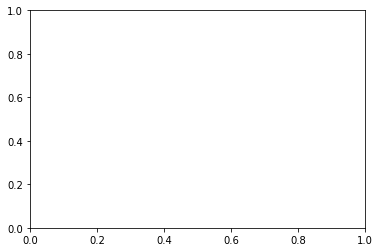

In [1202]:
fig, ax = plt.subplots()
ax.bar(evaluation.sort_values('coeff').coeff.values)
# plt.title('Correlation against wnv presence')
# plt.xticks(['june', 'CULEX RESTUANS', 'july', 'Longitude', 'Heat',
#        'ResultSpeed', 'CULEX TERRITANS', 'AvgSpeed', 'StnPressure',
#        'PrecipTotal', 'CULEX SALINARIUS', 'may', 'CULEX TARSALIS',
#        'CULEX ERRATICUS', 'distances', 'ResultDir', 'september',
#        'CULEX PIPIENS/RESTUANS', 'Latitude', 'precips', 'Depart', 'Tavg',
#        'DewPoint', 'CULEX PIPIENS', 'aug'])

In [1172]:
evaluation.sort_values('coeff').name.values

array([6, 'CULEX RESTUANS', 7, 'Longitude', 'Heat', 'ResultSpeed',
       'CULEX TERRITANS', 'AvgSpeed', 'StnPressure', 'PrecipTotal',
       'CULEX SALINARIUS', 5, 'CULEX TARSALIS', 'CULEX ERRATICUS',
       'distances', 'ResultDir', 9, 'CULEX PIPIENS/RESTUANS', 'Latitude',
       'precips', 'Depart', 'Tavg', 'DewPoint', 'CULEX PIPIENS', 8], dtype=object)

ValueError: shape mismatch: objects cannot be broadcast to a single shape

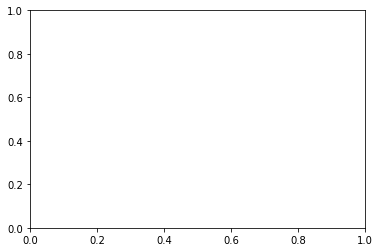

In [1167]:
fig, ax = plt.subplots()
ind = np.arange(1, (len(X)+1))
ax.bar(ind, evaluation.sort_values('coeff').coeff.values)

TypeError: unsupported operand type(s) for -: 'str' and 'float'

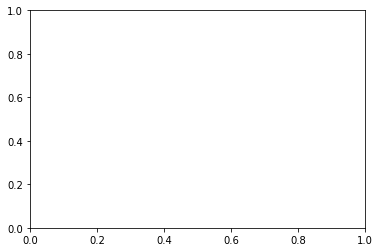

In [1164]:
# fig, ax = plt.subplots()
# ax.bar()
plt.bar(evaluation.sort_values('coeff').name.values, 
         evaluation.sort_values('coeff').coeff.values)

### Time vs Num Mosquitos
Get plots that show how number of mosquitos change with respect to time for traps that are near a particular spray event

In [895]:
X.head()

,Latitude,Longitude,Tavg,Depart,DewPoint,Heat,PrecipTotal,StnPressure,ResultSpeed,ResultDir,...,CULEX SALINARIUS,CULEX TARSALIS,CULEX TERRITANS,5,6,7,8,9,distances,precips
0,41.954690,-87.800991,74.0,10.0,58,0.0,0.0,29.39,5.8,18,...,0,0,0,1,0,0,0,0,0.019174,1.792
1,41.954690,-87.800991,74.0,10.0,58,0.0,0.0,29.39,5.8,18,...,0,0,0,1,0,0,0,0,0.019174,1.792
2,41.994991,-87.769279,74.0,10.0,58,0.0,0.0,29.39,5.8,18,...,0,0,0,1,0,0,0,0,0.016445,1.792
3,41.974089,-87.824812,74.0,10.0,58,0.0,0.0,29.39,5.8,18,...,0,0,0,1,0,0,0,0,0.418028,1.792
4,41.974089,-87.824812,74.0,10.0,58,0.0,0.0,29.39,5.8,18,...,0,0,0,1,0,0,0,0,0.418028,1.792


In [898]:
train['distances'] = X['distances']

In [903]:
train[['Trap', 'distances']].sort_values(by='distanecs').head(100)

KeyError: 'distanecs'

In [906]:
X.to_csv('./X.csv')

In [911]:
ts1 = pd.to_datetime('2013-01-01')

In [914]:
ts1

Timestamp('2013-01-01 00:00:00')

In [916]:
train['Date'] = pd.to_datetime(train['Date'])

Text(0.5,1,'Histogram of Spraying')

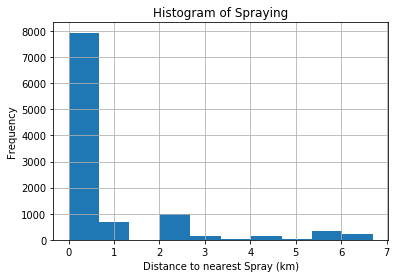

In [923]:
train.distances.sort_values().hist()
plt.xlabel('Distance to nearest Spray (km)')
plt.ylabel('Frequency')
plt.title('Histogram of Spraying')

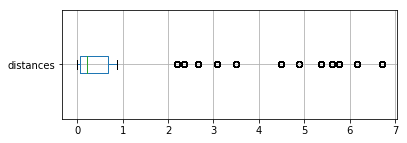

In [941]:
train.boxplot('distances', figsize=(6, 2), vert=False)


In [954]:
spray['Date'] = pd.to_datetime(spray['Date'])

### Anothe question arose: do we spray in same locations every time?

What I'd like to do, is check how number of mosquitos changed with respect to time for traps that are in the vicinity of a spray event, versus traps that are further away from a spray event. Then see what the correlation is between distance and avg number of mosquitos for the next couple days. 

In [961]:
# Dates of collections
train[(train['Date'] > ts1) & (train['distances'] < .01)].groupby('Date').NumMosquitos.mean()

Date
2013-06-07     4.200000
2013-06-14    12.428571
2013-06-21    12.153846
2013-06-27    13.333333
2013-06-28    21.600000
2013-07-08    20.666667
2013-07-12    28.950000
2013-07-19    27.958333
2013-07-25    20.235294
2013-08-01    16.777778
2013-08-08    22.782609
2013-08-15    14.666667
2013-08-22    19.300000
2013-08-29    25.866667
2013-09-06    15.285714
2013-09-12    18.923077
2013-09-19    11.909091
2013-09-26     7.900000
Name: NumMosquitos, dtype: float64

In [964]:
# 2013 spray dates
spray[spray['Date'] > pd.to_datetime('2013-07-1')].Date.drop_duplicates()

2209    2013-07-17
4411    2013-07-25
6018    2013-08-08
7213    2013-08-15
9881    2013-08-16
10022   2013-08-22
11609   2013-08-29
13911   2013-09-05
Name: Date, dtype: datetime64[ns]

In [994]:

for date in spray[spray['Date'] > pd.to_datetime('2013-07-1')].Date.drop_duplicates().index.values:
    print(date)

2209
4411
6018
7213
9881
10022
11609
13911


In [967]:
dates_of_sprays = {}
for date in spray[spray['Date'] > pd.to_datetime('2013-07-1')].Date.drop_duplicates().index.values:
spray[spray['Date'] > pd.to_datetime('2013-07-1')].Date.drop_duplicates():
    dates_of_sprays[date] = spray_locs()

In [993]:
spray[spray.Date == spray[spray['Date'] > 
                          pd.to_datetime('2013-07-1')].Date.drop_duplicates()[2209]][['Latitude', 'Longitude']]

,Latitude,Longitude
2209,41.997728,-87.767532
2210,41.997990,-87.768085
2211,41.998237,-87.768623
2212,41.998510,-87.769225
2213,41.998793,-87.769833
2214,41.999080,-87.770452
2215,41.999377,-87.771073
2216,41.999675,-87.771713
2217,41.999958,-87.772302
2218,42.000262,-87.772937


In [969]:
calendar.month_abbr[pd.to_datetime('2013-07-17').month]

'Jul'

In [979]:
def title_returner(date):
    ts = pd.to_datetime(date)
    title = '{}_{}'.format(calendar.month_abbr[ts.month], ts.day)
    return title

def spray_locs(date):
    coordinates = spray[spray.Date == pd.to_datetime(date)][['Latitude', 'Longitude']]
    return coordinates

In [981]:
title_returner('2013-07-17')

'Jul_17'

In [983]:
title_returner('2013-07-17')

'Jul_17'

In [984]:
Jul_17 = spray_locs('2013-07-17')

In [1134]:
# 2013 spray dates
times = spray[spray['Date'] > pd.to_datetime('2013-07-1')].Date.drop_duplicates().values

In [1135]:
times

array(['2013-07-17T00:00:00.000000000', '2013-07-25T00:00:00.000000000',
       '2013-08-08T00:00:00.000000000', '2013-08-15T00:00:00.000000000',
       '2013-08-16T00:00:00.000000000', '2013-08-22T00:00:00.000000000',
       '2013-08-29T00:00:00.000000000', '2013-09-05T00:00:00.000000000'], dtype='datetime64[ns]')

In [996]:
jul_13_sprays = spray[spray.Date == pd.to_datetime('2013-07-17')][['Latitude', 'Longitude']]
jul_13_sprays = spray[spray.Date == pd.to_datetime('2013-07-25')][['Latitude', 'Longitude']]
aug_08_sprays = spray[spray.Date == pd.to_datetime('2013-08-08')][['Latitude', 'Longitude']]
aug_15_sprays = spray[spray.Date == pd.to_datetime('2013-08-15')][['Latitude', 'Longitude']]
aug_16_sprays = spray[spray.Date == pd.to_datetime('2013-08-16')][['Latitude', 'Longitude']]
aug_22_sprays = spray[spray.Date == pd.to_datetime('2013-08-22')][['Latitude', 'Longitude']]
aug_29_sprays = spray[spray.Date == pd.to_datetime('2013-08-29')][['Latitude', 'Longitude']]
sep_05_sprays = spray[spray.Date == pd.to_datetime('2013-09-05')][['Latitude', 'Longitude']]

In [998]:
trap_cords

[(-87.800990999999996, 41.954689999999999),
 (-87.769278999999997, 41.994990999999999),
 (-87.824811999999994, 41.974088999999999),
 (-87.666454999999999, 41.921599999999998),
 (-87.654491000000007, 41.891117999999999),
 (-87.654223999999999, 41.867108000000002),
 (-87.655231999999998, 41.896281999999999),
 (-87.694259000000002, 41.919342999999998),
 (-87.632085000000004, 41.921965),
 (-87.676709000000002, 41.688324000000001),
 (-87.648859999999999, 41.862291999999997),
 (-87.666014000000004, 41.720847999999997),
 (-87.677511999999993, 41.731921999999997),
 (-87.611559999999997, 41.891126),
 (-87.795585000000003, 41.999128999999996),
 (-87.687768999999989, 42.017429999999997),
 (-87.760885999999999, 41.907645000000002),
 (-87.649642, 41.732984000000002),
 (-87.812826999999999, 41.981964000000005),
 (-87.832763, 41.944868999999997),
 (-87.811506000000008, 42.011600999999999),
 (-87.698456999999991, 41.949829999999999),
 (-87.750938000000005, 41.979242999999997),
 (-87.689778000000004, 4

In [999]:
trap_cords = []
for row in traps.index.values:
    trap_cords.append((traps.Longitude[row], traps.Latitude[row]))

In [1001]:
jul_13_cords = []
for val in jul_13_sprays.index.values:
    jul_13_cords.append((jul_13_sprays.Longitude[val], jul_13_sprays.Latitude[val]))

In [1002]:
jul_13_cords

[(-87.739783333333307, 41.960520000000002),
 (-87.739786666666703, 41.960515000000001),
 (-87.739786666666703, 41.960508333333294),
 (-87.739791666666704, 41.960498333333298),
 (-87.739800000000002, 41.960526666666702),
 (-87.739840000000001, 41.960371666666703),
 (-87.739800000000002, 41.959708333333296),
 (-87.739596666666699, 41.95928),
 (-87.739036666666692, 41.9590033333333),
 (-87.738465000000005, 41.958905000000001),
 (-87.738071666666698, 41.956316666666702),
 (-87.738060000000004, 41.955843333333299),
 (-87.738015000000004, 41.955266666666702),
 (-87.737991666666701, 41.954598333333294),
 (-87.737984999999995, 41.954063333333295),
 (-87.737973333333301, 41.953403333333299),
 (-87.7379416666667, 41.9528483333333),
 (-87.737928333333301, 41.952473333333295),
 (-87.7378966666667, 41.952024999999999),
 (-87.737951666666703, 41.951601666666704),
 (-87.737933333333302, 41.951084999999999),
 (-87.737911666666704, 41.950548333333295),
 (-87.737919999999988, 41.950029999999998),
 (-87.

In [1003]:
locs = []
for j in tqdm.tqdm(trap_cords):
    locs.append([vincenty(j, cord).kilometers for cord in jul_13_cords])

100%|██████████| 151/151 [00:04<00:00, 36.76it/s]


In [1013]:
min(locs[0])

6.830138646065171

In [1033]:
min_jul_13_sprays = []
for lst in locs:
    min_jul_13_sprays.append(min(lst))
cols = ['spray_distance']
min_jul_13_sprays = pd.DataFrame(min_jul_13_sprays, columns=cols)
min_jul_13_sprays['trap'] = traps.Trap.values

In [1075]:
min_jul_13_sprays.sort_values('spray_distance').head(10)

,spray_distance,trap
125,0.002538,T218A
136,0.002573,T228
42,0.002858,T218
44,0.006637,T001
126,0.027800,T218C
112,0.099491,T027
73,0.145654,T039
127,0.175795,T218B
62,0.188291,T030
51,0.388827,T040


In [1078]:
min_jul_13_sprays.sort_values('spray_distance').tail(10)

,spray_distance,trap
122,17.837029,T200A
100,18.052657,T209
124,18.395689,T200B
99,18.446176,T206
115,18.956173,T221
111,19.187842,T103
101,19.338899,T212
109,19.723666,T100
102,19.734538,T215
118,21.350557,T903


In [1061]:
ts1 = pd.to_datetime('2013-1-1')
ts2 = pd.to_datetime('2013-07-25')

In [1063]:
close_proximity = train.loc[(train['Date'] > ts1) & (train['Date'] < ts2)][train['Trap'].isin(['T218A', 'T228', 'T218', 'T001', 'T218C', 'T027', 'T039', 'T218B',
       'T030', 'T040'])][['Date', 'NumMosquitos']].groupby('Date').NumMosquitos.mean()

/Users/trevorwhite/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


In [1070]:
far_proximity = train.loc[(train['Date'] > ts1) & (train['Date'] < ts2)][train['Trap'].isin(['T200A', 'T209', 'T200B', 'T206', 'T221', 'T103', 'T212', 'T100',
       'T215', 'T903'])][['Date', 'NumMosquitos']].groupby('Date').NumMosquitos.mean()

/Users/trevorwhite/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


In [ ]:
plt.plot(df.index, df.A)
plt.plot(df[df.weekend=='yes'].index, df[df.weekend=='yes'].A, 'ro')


In [1084]:
close_proximity.index

DatetimeIndex(['2013-06-07', '2013-06-14', '2013-06-21', '2013-06-27',
               '2013-07-08', '2013-07-12', '2013-07-19'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [1086]:
ts1 = pd.to_datetime('2013-07-17')

Text(0,0.5,'NumMosquitos')

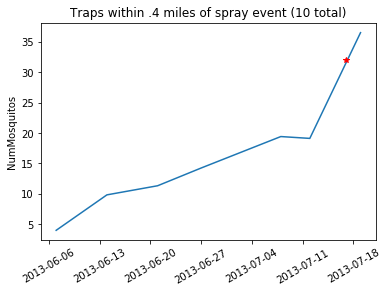

In [1096]:
fig, ax = plt.subplots()
ax.plot(close_proximity.index, close_proximity.values)
ax.plot()
plt.xticks(rotation=30)
ax.plot(ts1, 32, 'r*')
plt.title('Traps within .4 miles of spray event (10 total)')
plt.ylabel('NumMosquitos')


Text(0.5,1,'Traps within .4 miles of spray event (10 total)')

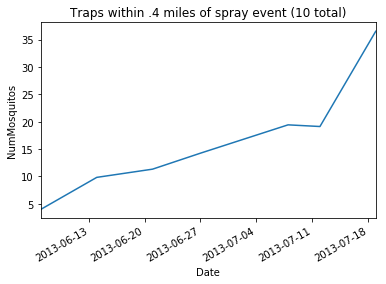

In [1077]:
close_proximity.plot()
plt.ylabel('NumMosquitos')
plt.title('Traps within .4 miles of spray event (10 total)')
plot(x_pos,y_pos,'r*')

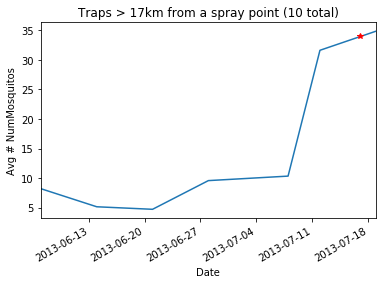

In [1100]:
far_proximity.plot()
plt.ylabel('Avg # NumMosquitos')
plt.title('Traps > 17km from a spray point (10 total)')
plt.plot(ts1, 34, 'r*')

/Users/trevorwhite/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


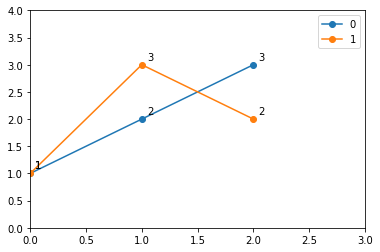

In [1082]:
z=pd.DataFrame( np.array([[1,2,3],[1,3,2]]).T )

z.plot(marker='o') # Plot the data, with a marker set.
plt.xlim(0,3) # Change the axes limits so that we can see the annotations.
plt.ylim(0,4)
ax = plt.gca()
for i in z.index: # iterate through each index in the dataframe
    for v in z.ix[i].values: # and through each value being plotted at that index
        # annotate, at a slight offset from the point.
        ax.annotate(str(v),xy=(i,v), xytext=(5,5), textcoords='offset points')

In [1109]:
far_traps = train['distances'].drop_duplicates().sort_values().tail(13).index.values

In [1130]:
near_traps = train['distances'].drop_duplicates().sort_values().head(13).index.values

In [1131]:
near_traps = train.loc[near_traps, :].Trap.values

In [1113]:
far_traps = train.loc[far_traps, :].Trap.values

In [1122]:
ts = pd.to_datetime('2013-01-01')

In [ ]:
plt.plot([70, 70], [100, 250], 'k-', lw=2)

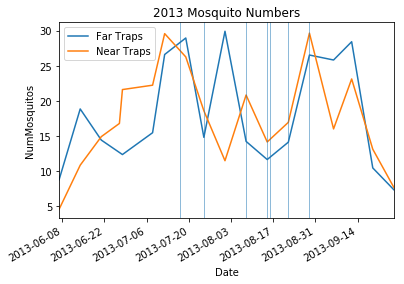

In [1152]:
train[train.Trap.isin(far_traps)][train[train.Trap.isin(far_traps)]['Date'] > ts].groupby('Date').NumMosquitos.mean().plot(label='Far Traps')

train[train.Trap.isin(near_traps)][train[train.Trap.isin(near_traps)]['Date'] > ts].groupby('Date').NumMosquitos.mean().plot(label='Near Traps')
plt.ylabel('Mean NumMosquitos in Trap')
plt.title('2013 Mosquito Numbers')
plt.ylabel('NumMosquitos')
plt.legend()
plt.axvline(x=times[0], linewidth=0.5)
plt.axvline(x=times[1], linewidth=0.5)
plt.axvline(x=times[2], linewidth=0.5)
plt.axvline(x=times[3], linewidth=0.5)
plt.axvline(x=times[4], linewidth=0.5)
plt.axvline(x=times[5], linewidth=0.5)
plt.axvline(x=times[6], linewidth=0.5)

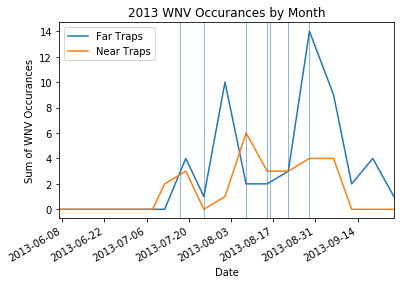

In [1155]:
train[train.Trap.isin(far_traps)][train[train.Trap.isin(far_traps)]['Date'] > ts].groupby('Date').WnvPresent.sum().plot(label='Far Traps')

train[train.Trap.isin(near_traps)][train[train.Trap.isin(near_traps)]['Date'] > ts].groupby('Date').WnvPresent.sum().plot(label='Near Traps')
plt.title('2013 WNV Occurances by Month')
plt.ylabel('Sum of WNV Occurances')
plt.legend()
plt.axvline(x=times[0], linewidth=0.5)
plt.axvline(x=times[1], linewidth=0.5)
plt.axvline(x=times[2], linewidth=0.5)
plt.axvline(x=times[3], linewidth=0.5)
plt.axvline(x=times[4], linewidth=0.5)
plt.axvline(x=times[5], linewidth=0.5)
plt.axvline(x=times[6], linewidth=0.5)

Text(0.5,1,'Traps that are 2+km away from a trap (13 total)')

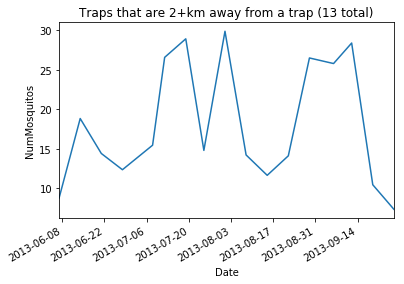

In [1129]:
train[train.Trap.isin(far_traps)][train[train.Trap.isin(far_traps)]['Date'] > ts].groupby('Date').NumMosquitos.mean().plot()
plt.ylabel('NumMosquitos')
plt.title('Traps that are 2+km away from a trap (13 total)')

In [1007]:
len(locs[0])

1607

In [947]:
train[(train['Date'] > ts1) & (train['distances'] < .01)].groupby('Date').NumMosquitos.mean()

Date
2013-06-07     4.200000
2013-06-14    12.428571
2013-06-21    12.153846
2013-06-27    13.333333
2013-06-28    21.600000
2013-07-08    20.666667
2013-07-12    28.950000
2013-07-19    27.958333
2013-07-25    20.235294
2013-08-01    16.777778
2013-08-08    22.782609
2013-08-15    14.666667
2013-08-22    19.300000
2013-08-29    25.866667
2013-09-06    15.285714
2013-09-12    18.923077
2013-09-19    11.909091
2013-09-26     7.900000
Name: NumMosquitos, dtype: float64

In [910]:
train.groupby('Date').NumMosquitos.mean()

Date
2007-05-29     1.600000
2007-06-05     2.116667
2007-06-26     3.085714
2007-06-29     1.847826
2007-07-02     3.243243
2007-07-11     7.256579
2007-07-18     6.612403
2007-07-19    15.266667
2007-07-25    44.228261
2007-07-27     2.975904
2007-08-01    12.529946
2007-08-02    21.153285
2007-08-03    40.800000
2007-08-07     9.673913
2007-08-08    45.010753
2007-08-09    19.500000
2007-08-15    16.887681
2007-08-16    48.978495
2007-08-17    35.462963
2007-08-21     8.962366
2007-08-22    32.460432
2007-08-24     7.946237
2007-08-28    39.566667
2007-09-04     5.695652
2007-09-05    22.208791
2007-09-06    30.220000
2007-09-12     8.837037
2007-09-18     4.215054
2007-09-19    14.276423
2007-09-24     9.401198
                ...    
2011-07-25    13.681564
2011-07-29    10.202899
2011-08-05     7.607143
2011-08-12     6.437500
2011-08-19     4.949580
2011-08-26     4.622642
2011-09-01     5.145161
2011-09-02    11.020000
2011-09-12     5.318841
2011-09-16     6.841667
2011-09-23 